In [2]:
import os
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import numpy as np
import pandas as pd
import logging
import re

In [1]:
WD = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/'
os.chdir(WD)
print(os.getcwd())

/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx


In [3]:
from train_models import SpectralConv1d, FNO1dComplexTime, TimeDataSetLinearResiduals

In [59]:
TRAIN_DF = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/results/00_one_step_train.txt'
TEST_DF = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/results/00_one_step_test.txt'
DATA_FP = '/local/meliao/projects/fourier_neural_operator/data/2021-06-24_NLS_data_04_test.mat'
MODEL_FP = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/models/00_residual_ep_500'
BASELINE_FP = '/local/meliao/projects/fourier_neural_operator/experiments/08_FNO_pretraining/models/00_pretrain_ep_1000'
# PLOTS_DIR = '/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/plots/'
PLOTS_DIR = 'one_step_plots/'
RESULTS_DIR = 'results/'


In [5]:
def make_train_test_plot(a_train, a_test, fp=None, title=""):
    fig, ax = plt.subplots(1, 2, sharey=False)
    fig.patch.set_facecolor('white')
#     fig.set_size_inches(6.4, 5.2)


    # a_train and a_test are the time-dependent FNO data. They're in the first column
    ax[0].set_title("Train")
    ax[0].plot(a_train.epoch, a_train.MSE, '-', color='red', label='train')
    ax[1].plot(a_test.epoch, a_test.test_mse, '--', color='red', label='test')
    ax[0].set_xlabel("Epoch", fontsize=13)
    ax[1].set_xlabel("Epoch", fontsize=13)
    # ax[0].legend()
    ax[0].set_yscale('log')

    ax[0].set_ylabel("MSE", fontsize=13)

    # b_train and b_test are the time-dependent. They're in the seecond column
    ax[1].set_title("Test")
    # ax[1].plot(b_train.epoch, b_train.MSE, '-', color='blue', label='train')
    # ax[1].plot(b_test.epoch, b_test.test_mse, '--', color='blue', label='test')
    ax[1].set_xlabel("Epoch", fontsize=13)
    ax[1].set_yscale('log')
    # ax[1].legend(fontsize=13)

    fig.suptitle(title)

#     plt.tight_layout()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)

In [25]:
# TRAIN_PATTERN = "/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/results/residuals_lr_exp_{}_train.txt"
# TEST_PATTERN = "/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/results/residuals_lr_exp_{}_test.txt"
# for i in [-5, -4, -3, -2.5, -2, -2.5, -1, -0.5, 0, 1]:
#     df_test_i = pd.read_table(TEST_PATTERN.format(i))
#     df_train_i = pd.read_table(TRAIN_PATTERN.format(i))
#     fp_out_i = os.path.join(PLOTS_DIR, 'train_test_{}.png'.format(i))
#     t = "Learning Rate: 10e{}".format(i)
#     make_train_test_plot(df_train_i, df_test_i, fp=fp_out_i, title=t)

results_lst = []
res_re = re.compile("one_step_lr_exp_(.*)_l2_exp_(.*)")
for f in os.listdir(RESULTS_DIR):
    if not f.endswith("_train.txt"):
        continue
    else:
        fname = f.rstrip("_train.txt")
        print("WORKING ON", fname)
        fp_train = os.path.join(RESULTS_DIR, fname + "_train.txt")
        fp_test = os.path.join(RESULTS_DIR, fname + "_test.txt")
        title = fname.split('/')[-1]
        df_train_i = pd.read_table(fp_train)
        df_test_i = pd.read_table(fp_test)
        
        # Find min test error
        dd_i = {}
        dd_i['min_test_error'] = df_test_i.test_mse.mean()
        search_obj = res_re.search(title)
        if search_obj is None:
            continue
        dd_i['lr_exp'] = float(search_obj.group(1))
        dd_i['l2_exp'] = float(search_obj.group(2))
        
        # Make plot of train/test errors
        fp_out_train_test_plot = os.path.join(PLOTS_DIR, "train_test_" + title + ".png")
        plt_title = "LR=10e{}, L2 Reg=10e{}".format(dd_i['lr_exp'], dd_i['l2_exp'])
        make_train_test_plot(df_train_i, df_test_i, fp=fp_out_train_test_plot, title=plt_title)
        

        print(dd_i)
        # Save result into a list of dictionaries
        results_lst.append(dd_i)
        

WORKING ON one_step_lr_exp_-1.5_l2_exp_-4
{'min_test_error': 4.17500882607419, 'lr_exp': -1.5, 'l2_exp': -4.0}
WORKING ON residuals_lr_exp_-1.5_l2_exp_-2
WORKING ON residuals_lr_exp_-1.5_l2_exp_-1
WORKING ON residuals_lr_exp_-0.5_l2_exp_-1
WORKING ON one_step_lr_exp_-1.5_l2_exp_-2.5
{'min_test_error': 0.3824266218813136, 'lr_exp': -1.5, 'l2_exp': -2.5}
WORKING ON residuals_lr_exp_-2_l2_exp_1
WORKING ON residuals_lr_exp_-1.5_l2_exp_-5
WORKING ON residuals_lr_exp_-0.5_l2_exp_0
WORKING ON residuals_lr_exp_-3_l2_exp_-5
WORKING ON residuals_lr_exp_-2.5_l2_exp_-0.5
WORKING ON residuals_lr_exp_-0.5_l2_exp_-3
WORKING ON one_step_lr_exp_-2_l2_exp_-5
{'min_test_error': 0.02152437755867135, 'lr_exp': -2.0, 'l2_exp': -5.0}
WORKING ON residuals_lr_exp_-3_l2_exp_-4
WORKING ON residuals_lr_exp_-2_l2_exp_-1.5
WORKING ON residuals_lr_exp_-3_l2_exp_-0.5
WORKING ON residuals_lr_exp_-5_l2_exp_1
WORKING ON one_step_lr_exp_-2_l2_exp_-2.5
{'min_test_error': 0.02173473468283186, 'lr_exp': -2.0, 'l2_exp': -2.5

In [26]:
r_df = pd.DataFrame(results_lst).pivot(index='lr_exp', columns='l2_exp', values='min_test_error')
print(r_df.head(40))

l2_exp      -5.0      -4.0      -3.0      -2.5      -2.0
lr_exp                                                  
-4.0    0.049842  0.049930  0.051487  0.053977  0.059059
-3.0    0.016427  0.016058  0.020145  0.033774  0.042950
-2.5    0.013749  0.014017  0.016258  0.031736  0.042709
-2.0    0.021524  0.021024  0.020274  0.021735  0.044976
-1.5    5.204577  4.175009  1.291795  0.382427  0.081162


In [27]:
def plot_heatmap(values, vals_y, label_y, vals_x, label_x, title, cbarlabel='', fp=None):
    # l1_axis = np.unique(lambda_1) #Lambda 1 on vertical
    # l2_axis = np.unique(lambda_2) #Lambda 2 on horizontal
    # values_arr = values.reshape((l1_axis.shape[0], l2_axis.shape[0]))
#     values = np.log10(values)
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')
    im = ax.imshow(values, origin='lower')
    ax.set_xticks([i for i in range(vals_x.shape[0])])
    ax.set_xticklabels(vals_x)
    # ax.set_xticklabels(["{:.2f}".format(i) for i in l2_axis])
    ax.set_xlabel(label_x, size=14)
    ax.set_yticks([i for i in range(vals_y.shape[0])])
    ax.set_yticklabels(vals_y)
    # ax.set_yticklabels(["{:.2f}".format(i) for i in l1_axis])
    ax.set_ylabel(label_y, size=14)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label(cbarlabel)
    # plt.tight_layout()
    plt.title(title)
    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)
r_df = r_df[r_df.index < -1.5]
# r_df = r_df[[-2., -1.5, -1.0, -0.5, 0., 1.]]

fp_heatmap=os.path.join(PLOTS_DIR, 'one_step_heatmap_TDLRP_test_errors.png')
plot_heatmap(r_df.values,
            vals_y=r_df.index.values,
            label_y='$log_{10}$(Learning Rate)',
            vals_x=r_df.columns.values,
            label_x='$log_{10}$(L2 reg.)',
            title='TDLRP test error',
            cbarlabel='min test error',
            fp=fp_heatmap)

In [65]:
TRAIN_DF = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/results/one_step_lr_exp_-2.5_l2_exp_-4_train.txt'
TEST_DF = '/local/meliao/projects/fourier_neural_operator/experiments/10_linear_approx/results/one_step_lr_exp_-2.5_l2_exp_-4_test.txt'


In [66]:
test_df = pd.read_table(TEST_DF)
train_df = pd.read_table(TRAIN_DF)
fp_out = os.path.join(PLOTS_DIR, 'one_step_train_test.png')
make_train_test_plot(train_df, test_df, fp=fp_out, title='One Step TDLRP Training')

In [8]:
MODEL_FP = 'models/one_step_lr_exp_-2.5_l2_exp_-4_ep_1000'
FNO_T_MODEL = '/local/meliao/projects/fourier_neural_operator/experiments/07_long_time_dependent_runs/models/00_time_dep_ep_1000'
DATA_FP = '/local/meliao/projects/fourier_neural_operator/data/2021-07-14_NLS_data_05_test.mat'
# BASELINE_FP = '/local/meliao/projects/fourier_neural_operator/experiments/08_FNO_pretraining/models/00_pretrain_ep_1000'

# DATA_FP = '/local/meliao/projects/fourier_neural_operator/data/2021-06-24_NLS_data_04_test.mat'
# MODEL_FP = '/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/models/00_residual_ep_500'
BASELINE_FP = '/local/meliao/projects/fourier_neural_operator/experiments/08_FNO_pretraining/models/00_pretrain_ep_1000'


In [9]:
d = sio.loadmat(DATA_FP)
tdlrp_model = torch.load(MODEL_FP, map_location='cpu')
fno_model = torch.load(BASELINE_FP, map_location='cpu')
fno_t_model = torch.load(FNO_T_MODEL, map_location='cpu')

In [10]:
# N_TPOINTS = 2
t_dset = TimeDataSetLinearResiduals(d['output'], d['t'], d['x'])
# t_dloader = torch.utils.data.DataLoader(t_dset, batch_size=1, shuffle=False)

In [11]:
def load_data(fp):
    logging.info("Loading data from {}".format(fp))
    data = sio.loadmat(os.path.expanduser(fp))
    return data['output'], data['t']

def load_model(fp, device):
    # Model datatypes are loaded from train_models.py
    model = torch.load(fp, map_location=device)
    return model

def l2_normalized_error(pred, actual):
    """Short summary.

    Parameters
    ----------
    pred : type
        Description of parameter `pred`.
    actual : type
        Description of parameter `actual`.

    Returns
    -------
    types
        Description of returned object.

    """
    errors = pred - actual
    error_norms = torch.linalg.norm(torch.tensor(errors), dim=-1, ord=2)
    actual_norms = torch.linalg.norm(torch.tensor(actual), dim=-1, ord=2)
    normalized_errors = torch.divide(error_norms, actual_norms)
    return normalized_errors.detach().numpy()
def prepare_input(X):
    # X has shape (nbatch, 1, grid_size)
    s = X.shape[-1]
    n_batches = X.shape[0]

    # Convert to tensor
    X_input = torch.view_as_real(torch.tensor(X, dtype=torch.cfloat))

    # FNO code appends the spatial grid to the input as below:
    x_grid = torch.linspace(-np.pi, np.pi, 1024).view(-1,1)
    X_input = torch.cat((X_input, x_grid.repeat(n_batches, 1, 1)), axis=2)

    return X_input

In [12]:
def test_TDLRP_predictions(model, fno_model, fno_t_model, t_dset):

    # X has shape (nbatch, n_tsteps, grid_size)
    TEST_KEYS = ['TDLRP', 'FNO', 'TD-FNO']
    preds_dd = {i: np.zeros((t_dset.X.shape[0], t_dset.X.shape[1]-1, t_dset.X.shape[2]), dtype=np.cdouble) for i in TEST_KEYS}
    errors_dd = {i: np.zeros((t_dset.X.shape[0], t_dset.X.shape[1]-1), dtype=np.double) for i in TEST_KEYS}

    one_tensor = torch.tensor(1, dtype=torch.float).repeat([t_dset.X.shape[0],1,1])
    IC_input = prepare_input(t_dset.X[:,0,:])

    # First input is given by the initial condition
    comp_input_i = prepare_input(t_dset.X[:,0,:])
    comp_input_j = prepare_input(t_dset.X[:,0,:])
    # Iterate along timesteps
    for i in range(t_dset.t.shape[0]-1):
        SOLN_I = torch.tensor(t_dset.X[:,i+1,:])
        # First test: composing the model
        comp_preds_i = fno_model(comp_input_i, one_tensor).detach().numpy()
        # comp_preds_i = emulator(comp_input_i).detach().numpy()
        preds_dd['FNO'][:,i,:] = comp_preds_i
        comp_input_i = prepare_input(comp_preds_i)
        errors_i = l2_normalized_error(torch.tensor(comp_preds_i), SOLN_I)
        errors_dd['FNO'][:,i] = errors_i

        # Second test: prediction from the TDLRP
        # if time_dep_model:
        i_tensor = torch.tensor(t_dset.t[i+1], dtype=torch.float).repeat([t_dset.X.shape[0],1,1])
        preds_k = model(comp_input_j, one_tensor).detach().numpy() + t_dset.linear_part_arr[:,i+1].numpy()
        preds_dd['TDLRP'][:,i,:] = preds_k
        comp_input_j = prepare_input(preds_k)
        errors_k = l2_normalized_error(torch.tensor(preds_k), SOLN_I)
        errors_dd['TDLRP'][:,i] = errors_k

        # Third test: prediction from FNO-T model
        preds_j = fno_t_model(IC_input, i_tensor).detach().numpy()
        preds_dd['TD-FNO'][:,i] = preds_j
        errors_dd['TD-FNO'][:,i] = l2_normalized_error(torch.tensor(preds_j), SOLN_I)
    # for k,v in errors_dd.items():
    #     print("{}: {}: {}".format(k, v.shape, v))
    return preds_dd, errors_dd



In [13]:
preds_dd, errors_dd = test_TDLRP_predictions(tdlrp_model, fno_model, fno_t_model, t_dset)

In [14]:
for k,v in errors_dd.items():
    print(k, v.shape)

TDLRP (100, 1)
FNO (100, 1)
TD-FNO (100, 1)


In [61]:
def bar_chart(errors_dd, title='', fp=None):
    keys_lst = list(errors_dd.keys())
    means_lst = [np.mean(errors_dd[k]) for k in keys_lst]
    stds_lst = [np.std(errors_dd[k]) for k in keys_lst]
    plt.bar(keys_lst, means_lst, yerr=stds_lst, capsize=5)
    plt.title(title)
    plt.ylabel("L_2 Normalized Error")
    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.clf()
bar_fp = os.path.join(PLOTS_DIR, 'bar_errors.png')
bar_chart(errors_dd, title="One Time Step Errors", fp=bar_fp)


<Figure size 432x288 with 0 Axes>

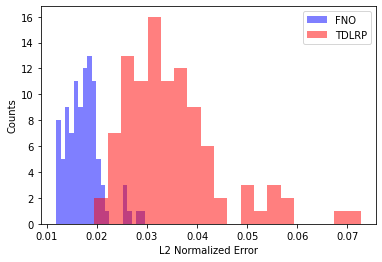

In [69]:
def make_hist(errors_dd, title='', fp=None):
    ALPHA=0.5
    BINS=20
    plt.hist(errors_dd['FNO'].flatten(), bins=BINS, color='blue', alpha=ALPHA, label='FNO')
    plt.hist(errors_dd['TDLRP'].flatten(), bins=BINS, color='red', alpha=ALPHA, label='TDLRP')
    plt.xlabel("L2 Normalized Error")
    plt.ylabel("Counts")
    plt.legend()
    plt.show()

make_hist(errors_dd)

In [37]:
def plot_time_errors(errors_dd, t_grid, title, fp):
    # SHOW_N_TSTEPS = t_grid.shape[1]
    SHOW_N_TSTEPS = 2

    n_t_steps = t_grid.shape[1]
    x_vals = t_grid.flatten()[:SHOW_N_TSTEPS]
    plt.figure().patch.set_facecolor('white')
    for k, v in errors_dd.items():
        print("{}: {}".format(k, v.shape))
        v_means = np.mean(v, axis=0)[:SHOW_N_TSTEPS]
        v_stds = np.std(v, axis=0)[:SHOW_N_TSTEPS]
        plt.plot(x_vals, v_means, label=k, alpha=0.7)
        plt.fill_between(x_vals,
                            v_means + v_stds,
                            v_means - v_stds,
                            alpha=0.3)
    plt.legend()
    plt.xlabel("Time step")
    plt.xticks(ticks=np.arange(0, SHOW_N_TSTEPS),
               labels=make_special_ticks(SHOW_N_TSTEPS),
              rotation=45,
              ha='right',
              )
    plt.ylabel("$L_2$-Normalized Errors")
    # plt.yscale('log')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fp)
    plt.clf()


def make_special_ticks(n):
    s = "$t={} \\ \\to  \\ t={}$"
    return [s.format(i, i+1) for i in range(n)]


In [38]:
fp_time_errors = os.path.join(PLOTS_DIR, 'one_step_time_errors.png')
errors_dd_i = {k:np.delete(v, [59], axis=0) for k,v in errors_dd.items()}
plot_time_errors(errors_dd_i, d['t'][:,:-1], "FNO vs. TDLRP: Test Dataset", fp_time_errors)

TDLRP: (99, 20)
FNO: (99, 20)
TD-FNO: (99, 20)


<Figure size 432x288 with 0 Axes>

In [63]:
def plot_one_testcase_heatmap_T(preds, resids, model_name, fp=None):
    INTERPOLATION = None
    CMAP='hot'
    CMAP_2='hot'
    XT, XT_STR = gen_ticks(0, 1023, -np.pi, np.pi, 5)
    ASPECT= (preds.shape[1] / preds.shape[0]) * 100/256

    # preds has shape (n_tsteps, grid_size)
    errors = np.abs(preds - resids)
    fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
    fig.set_size_inches(12.8, 9.6)
    im_0 = ax[0].imshow(np.abs(resids), interpolation=INTERPOLATION, aspect=ASPECT, cmap=CMAP)
    ax[0].set_title("NLS Nonlinear Residuals: $|u|$", fontsize=20)
    ax[2].set_xticks(XT)
    ax[2].set_xticklabels(XT_STR)
    ax[0].set_ylabel("$t$", fontsize=20)
    ax[1].set_ylabel("$t$", fontsize=20)
    im_1 = ax[1].imshow(np.abs(preds), interpolation=INTERPOLATION, aspect=ASPECT, cmap=CMAP)
    ax[1].set_title("{} Predictions: $|\\hat u |$".format(model_name), fontsize=20)
    im_2 = ax[2].imshow(errors, interpolation=INTERPOLATION, aspect=ASPECT, cmap=CMAP_2)
    ax[2].set_title("Absolute Errors: $| \\hat u - u |$", fontsize=20)
    ax[2].set_ylabel("$t$", fontsize=20)
    ax[2].set_xlabel("$x$", fontsize=20)
    fig.colorbar(im_0, ax=ax[0])
    fig.colorbar(im_1, ax=ax[1])
    fig.colorbar(im_2, ax=ax[2])
    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)


def gen_ticks(lb_im, ub_im, lb_world, ub_world, n_ticks):
    tick_locs = np.linspace(lb_im, ub_im, n_ticks)
    dist_world = ub_world - lb_world
    tick_names_flt = [lb_world + dist_world * i /ub_im for i in tick_locs]
    tick_names_str = ["{:.2f}".format(i) for i in tick_names_flt]
    return tick_locs, tick_names_str

def plot_testcases_tdlrp(tdlrp_preds, residuals, show_n_cases=5, fp=None):
    ALPHA = 0.7 # Controls saturation of overlapping lines. 1 is full saturation, 0 is none.
    # preds has shape (n_tsteps, grid_size)
    # _, grid_size = preds.shape
    # n_tsteps = SHOW_T_TIMESTEPS

    fig, ax = plt.subplots(show_n_cases, 3, sharex='col', sharey=False)
    fig.set_size_inches(15,4*show_n_cases) #15, 20 works well
    fig.patch.set_facecolor('white')

    ax[0,0].set_title("$Re(u)$", size=20)
    ax[0,1].set_title("$Im(u)$", size=20)
    ax[0,2].set_title("Errors", size=20)

    # residuals = solns - lin_part
    # preds = preds - lin_part
    # preds = TDLRP + lin_part
    # errors = solns - preds = solns - TDLRP - lin_part
    errors = residuals - tdlrp_preds

    for i in range(show_n_cases):
        # First column has Re(prediction), Re(solution)
        ax[i,0].plot(np.real(tdlrp_preds[i,1]), alpha=ALPHA, label='TDLRP preds')
        ax[i,0].plot(np.real(residuals[i,1]), '--', alpha=ALPHA, label='residuals')
        ax[i,0].set_ylabel("Test case {}".format(i), size=15)

        # Second column has Im(prediction), Im(solution)
        ax[i,1].plot(np.imag(tdlrp_preds[i,1]), alpha=ALPHA, label='TDLRP preds')
        ax[i,1].plot(np.imag(residuals[i,1]), '--', alpha=ALPHA, label='residuals')

        # Third column is Abs(prediction - solution)
        ax[i,2].plot(np.real(errors[i,1]), label='Real errors', color='red')
        ax[i,2].plot(np.imag(errors[i,1]), label='Imag errors', color='green')
        ax[i,2].hlines(0, xmin=0, xmax=errors.shape[2]-1, linestyles='dashed')

    ax[0,0].legend(fontsize=13, markerscale=2)
    # ax[0,1].legend(fontsize=13, markerscale=2)
    ax[0,2].legend(fontsize=13, markerscale=2)
    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)

def plot_testcases_fno(preds, solns, show_n_cases=5, fp=None):
    ALPHA = 0.7 # Controls saturation of overlapping lines. 1 is full saturation, 0 is none.
    # preds has shape (n_tsteps, grid_size)
    # _, grid_size = preds.shape
    # n_tsteps = SHOW_T_TIMESTEPS

    fig, ax = plt.subplots(show_n_cases, 3, sharex='col', sharey=False)
    fig.set_size_inches(15,4*show_n_cases) #15, 20 works well
    fig.patch.set_facecolor('white')
    ax[0,0].set_title("$Re(u)$", size=20)
    ax[0,1].set_title("$Im(u)$", size=20)
    ax[0,2].set_title("Errors", size=20)

    # residuals = solns - lin_part
    # preds = preds - lin_part
    # preds = TDLRP + lin_part
    # errors = solns - preds = solns - TDLRP - lin_part
    errors = solns - preds

    for i in range(show_n_cases):
        # First column has Re(prediction), Re(solution)
        ax[i,0].plot(np.real(preds[i,0]), alpha=ALPHA, label='FNO preds')
        ax[i,0].plot(np.real(solns[i,1]), '--', alpha=ALPHA, label='solutions')
        ax[i,0].set_ylabel("Test case {}".format(i), size=15)

        # Second column has Im(prediction), Im(solution)
        ax[i,1].plot(np.imag(preds[i,0]), alpha=ALPHA, label='FNO preds')
        ax[i,1].plot(np.imag(solns[i,1]), '--', alpha=ALPHA, label='solutions')

        # Third column is Abs(prediction - solution)
        ax[i,2].plot(np.real(errors[i,1]), label='Real errors', color='red')
        ax[i,2].plot(np.imag(errors[i,1]), label='Imag errors', color='green')
        ax[i,2].hlines(0, xmin=0, xmax=errors.shape[2]-1, linestyles='dashed')

    ax[0,0].legend(fontsize=13, markerscale=2)
    # ax[0,1].legend(fontsize=13, markerscale=2)
    ax[0,2].legend(fontsize=13, markerscale=2)
    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)

In [64]:
residuals = t_dset.X.numpy() - t_dset.linear_part_arr.numpy()
tdlrp_preds = preds_dd['TDLRP'] - t_dset.linear_part_arr.numpy()
fp_tdlrp = os.path.join(PLOTS_DIR, 'tdlrp_test_cases.png')
plot_testcases_tdlrp(tdlrp_preds, residuals, fp=fp_tdlrp)

print(preds_dd['FNO'].shape)
print(preds_dd['TDLRP'].shape)
fp_fno = os.path.join(PLOTS_DIR, 'fno_test_cases.png')
plot_testcases_fno(preds_dd['FNO'], t_dset.X.numpy(), fp=fp_fno)

# for i in range(1):
#     preds_i = np.zeros(t_dset.X[i].shape, dtype=np.cfloat) #t_dset.X[i].numpy()
#     preds_i[1:] = preds_dd['TDLRP'][i]
#     preds_i = preds_i - t_dset.linear_part_arr[i].numpy()
#     solns_i = t_dset.X[i].numpy() 
#     lin_part_i = t_dset.linear_part_arr[i].numpy()
#     resids_i = solns_i - lin_part_i
#     model_name = 'TDLRP'
#     fp_i = os.path.join(PLOTS_DIR, 'heatmap_test_case_{}.png'.format(i))
#     # plot_one_testcase_heatmap_T(preds_i, resids_i, model_name) #, fp=fp_i)
#     # plot_one_testcase_heatmap_T(preds_i + lin_part_i, solns_i, model_name) #, fp=fp_i)
#     plot_one_testcase_panels(preds_i, resids_i)

(100, 1, 1024)
(100, 1, 1024)
